# Selecciona el rectangulo para realizar la comparacion en la estabilizacion del video

Cuando aparece la imagen, hacer click y arrastrar para seleccionar el rectangulo, luego apretar la letra "c" para guardar la imagen, luego escape para continuar

In [3]:
import cv2
import numpy as np
fileName='uns.mp4'
cap = cv2.VideoCapture(fileName)

ret, old_frame = cap.read()

skipframe=5

for i in range (0,skipframe):
    ret, old_frame = cap.read()
    

cv2.imwrite("old_frame.jpg", old_frame)
cap.release()   

%run click_and_crop.py --image old_frame.jpg


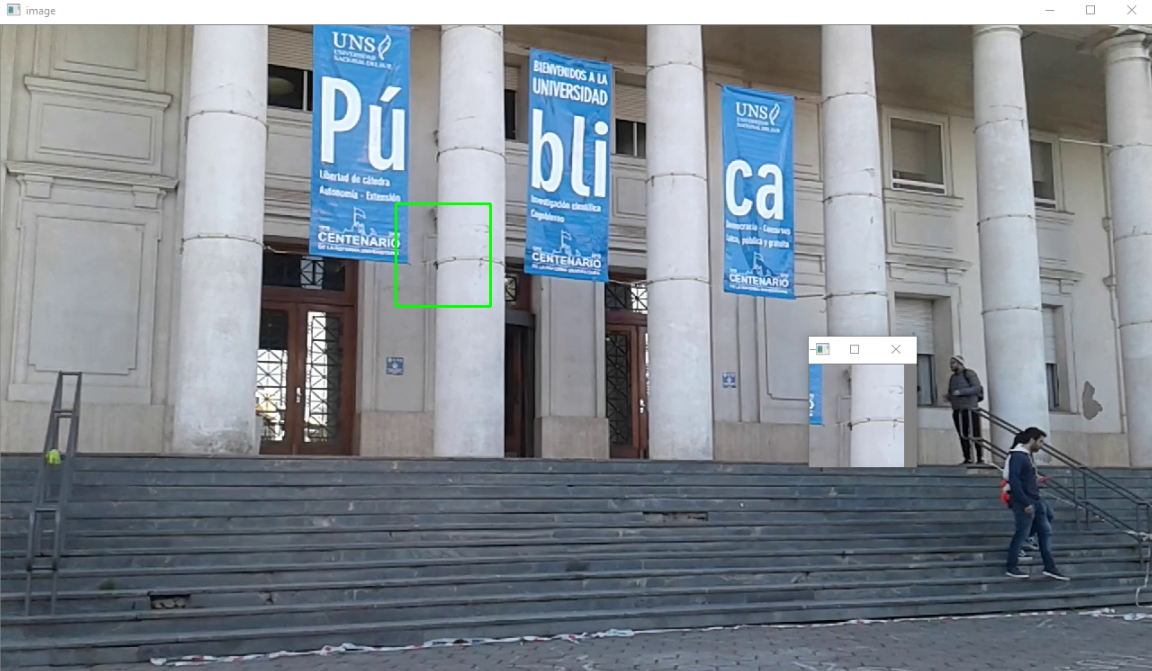

# Estabiliza el video

In [4]:
import cv2
import numpy as np

#Importar video

fileName='uns.mp4'
cap = cv2.VideoCapture(fileName)

ret, old_frame = cap.read()

#########################################################
skipframe=5

for i in range (0,skipframe):
    ret, old_frame = cap.read()
###########################################################



height , width , layers =  old_frame.shape

salida = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30,(width,height))
############################################################################################################################
#Click to take template

template = cv2.imread('template.jpg')
#############################################################################################################################


#primera deteccion de rectangulo
#img = cv2.cvtColor(old_frame,cv2.COLOR_BGR2GRAY)
img = old_frame
w, h ,l = template.shape[::-1]

# Apply template Matching
res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)

top_left_original = top_left
bottom_right_original = bottom_right

while(1):
    #img = cv2.cvtColor(old_frame,cv2.COLOR_BGR2GRAY)
    img = old_frame
    
    img2 = img.copy()
    w, h ,l= template.shape[::-1]
    # All the 6 methods for comparison in a list
    #methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
    #            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

    #img = img2.copy()
    # Apply template Matching
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
    
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    
    #transformacion para estabilizacion
    tx1 = top_left_original[0]-top_left[0]
    ty1 = top_left_original[1]-top_left[1]
    tx2 = bottom_right_original[0]-bottom_right[0]
    ty2 = bottom_right_original[1]-bottom_right[1]
    
    tx = (tx1+tx2)//2
    ty = (ty1+ty2)//2

    num_rows, num_cols = img.shape[:2]

    translation_matrix = np.float32([ [1,0,tx], [0,1,ty] ])
    img_translation = cv2.warpAffine(img2, translation_matrix, (num_cols, num_rows))
    
    img_translation=cv2.resize(img_translation,(width,height))
    
    salida.write(img_translation)
    
    cv2.imshow('Matching Result',res)
    cv2.imshow('Detected Point',img)
    cv2.imshow('Estabilizada',img_translation)
    k = cv2.waitKey(10) & 0xff
    if k == 27:
        break
    
    ret, old_frame = cap.read()
    if ret==0:
        break
    
cv2.destroyAllWindows()
salida.release()
cap.release()    

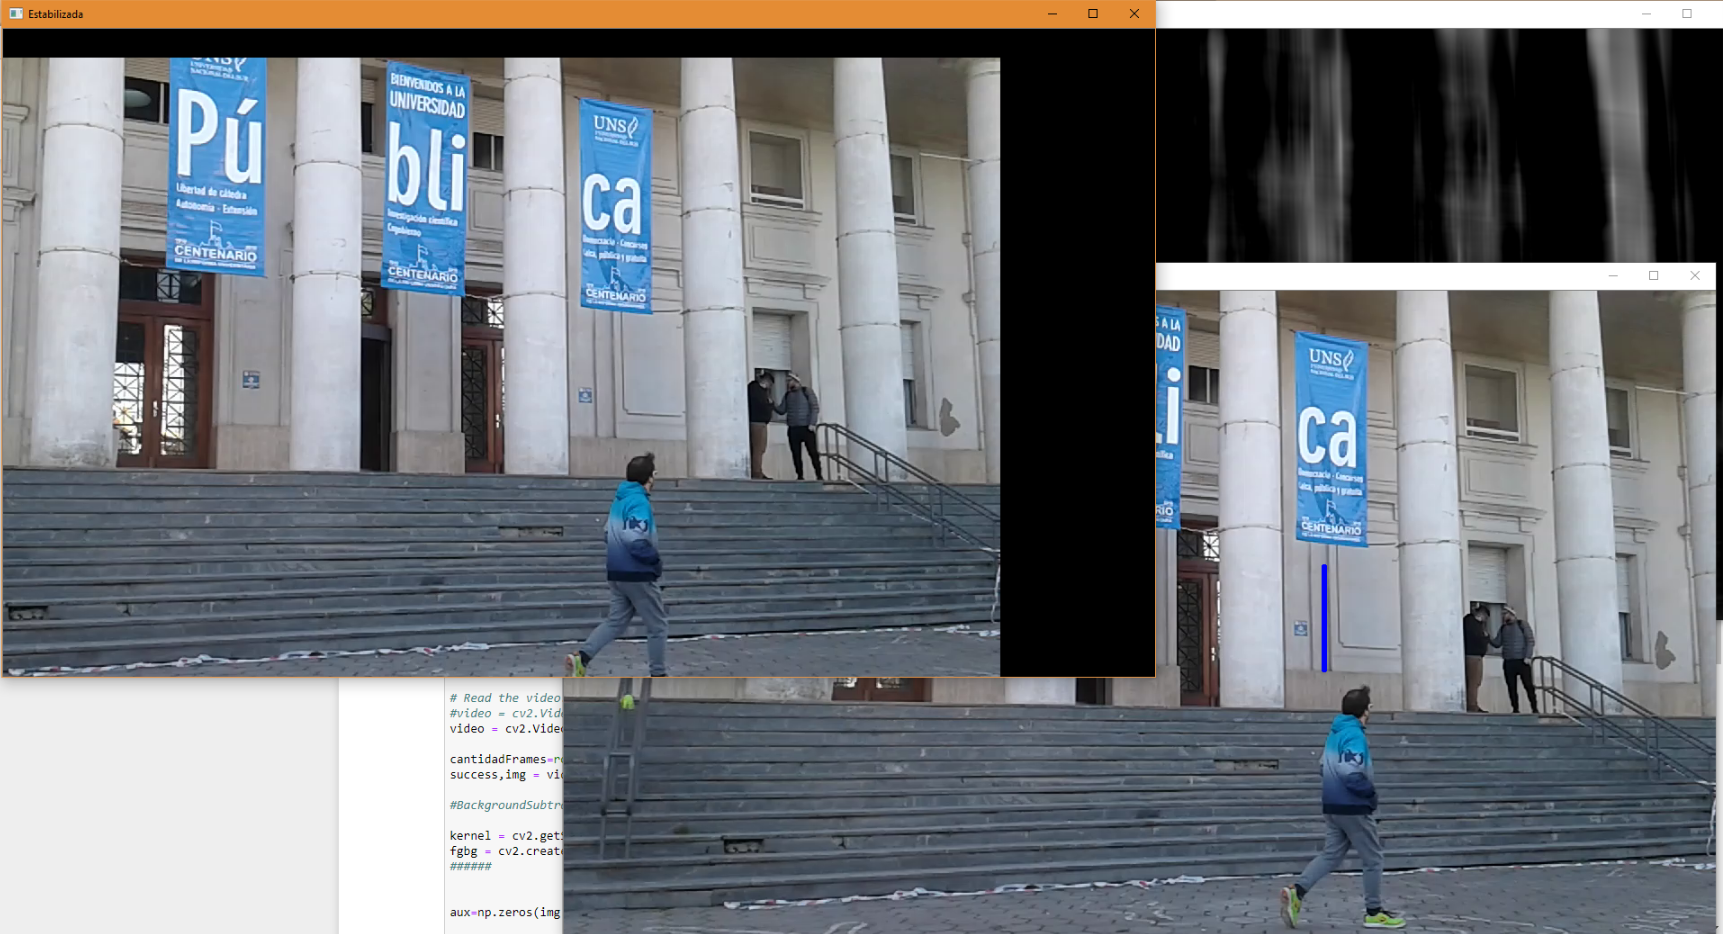

# Quita los obtaculos de la imagen

Realizando la suma de todo lo que esta afuera de los rectangulos y creando una matris para saber cuantas veces se sumo cada pixel

In [5]:
import numpy as np
import tensorflow as tf
import cv2

# Read the video.
#video = cv2.VideoCapture('video.avi')
video = cv2.VideoCapture('video.avi')

cantidadFrames=round(video.get(cv2.CAP_PROP_FRAME_COUNT))
success,img = video.read()

#BackgroundSubtractor

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorKNN()
######


aux=np.zeros(img.shape[:],dtype="uint64")#inicia el auxiliar en con los valores en 0

matrizContador=np.zeros(img.shape[:2],dtype="uint64")#matriz para contar cuantas veces se sumo cada pixel
maskAuxContador=np.zeros(img.shape[:2],dtype="uint8")#mascara de cada imagen
maskAuxContador[:,:]=1 #coloca la mascara del contador a 1

with tf.gfile.FastGFile('frozen_inference_graph.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

    
with tf.Session() as sess:
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
        
    for frame in range(1,cantidadFrames): 
            
        success,img = video.read()
        if success==0:#controla que queden frames
            break
        
        
        fgmask = fgbg.apply(img)
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
        mascara = cv2.bitwise_not(fgmask)    
        
        maskAuxContador[:,:]=1 #vuelve la mascara a blanco
        rows = img.shape[0]
        cols = img.shape[1]
        inp = cv2.resize(img, (300, 300))
        inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

        # Run the model
        out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                        sess.graph.get_tensor_by_name('detection_scores:0'),
                        sess.graph.get_tensor_by_name('detection_boxes:0'),
                        sess.graph.get_tensor_by_name('detection_classes:0')],
                       feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})

        # Visualize detected bounding boxes.
        num_detections = int(out[0][0])
        for i in range(num_detections):
            classId = int(out[3][0][i])
            score = float(out[1][0][i])
            bbox = [float(v) for v in out[2][0][i]]
            if score > 0.3:
                x = bbox[1] * cols
                y = bbox[0] * rows
                right = bbox[3] * cols
                bottom = bbox[2] * rows
                
                #crea mascara para la suma
                cv2.rectangle(img, (int(x), int(y)), (int(right), int(bottom)), (0, 0, 0), thickness=-1)
                cv2.rectangle(maskAuxContador, (int(x), int(y)), (int(right), int(bottom)), (0, 0, 0), thickness=-1)
    
        matrizceros=np.zeros(img.shape[:],dtype="uint8")
        matrizcerosCont=np.zeros(maskAuxContador.shape[:],dtype="uint8")
        
        img = cv2.add(img,matrizceros,mask=mascara)#enmascara la imagen dejando solamente el fondo
        maskAuxContador = cv2.add(maskAuxContador,matrizcerosCont,mask=mascara)
    
        aux=aux+np.uint64(img)#suma la imagen auxiliar con la nueva imagen enmascarada
        matrizContador=matrizContador+np.uint64(maskAuxContador)#suma a la matriz contador 1 menos en los pixeles enmascarados

        #para previsualizar la imagen
        
        aux2=np.zeros(img.shape[:],dtype="uint64")
        aux2[:,:,0] = np.divide(aux[:,:,0],matrizContador)
        aux2[:,:,1] = np.divide(aux[:,:,1],matrizContador)
        aux2[:,:,2] = np.divide(aux[:,:,2],matrizContador)
        
        ##############################

        cv2.imshow('TensorFlow MobileNet-SSD', np.uint8(aux2))
        cv2.imshow('Actual', cv2.putText(img,str(frame), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break        
            

        
cv2.imwrite("resultado.jpg", np.uint8(aux2))
cv2.imshow('Resultado', np.uint8(aux2))
cv2.waitKey()

cv2.destroyAllWindows()
video.release()

C:\Users\diego\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\diego\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide


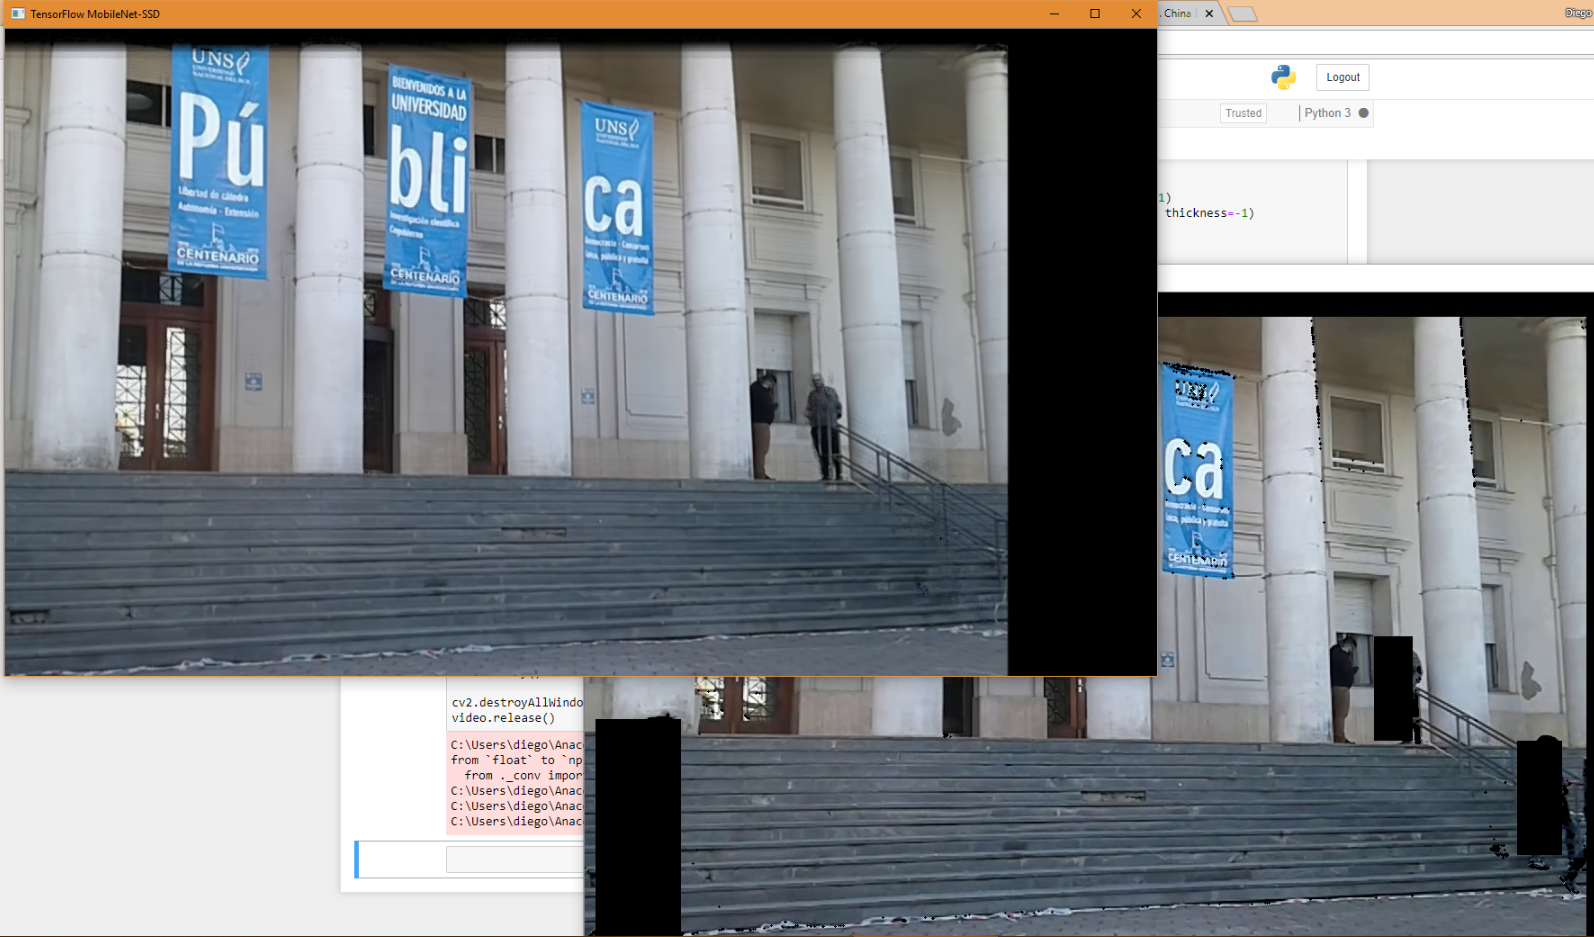